In [1]:
import keras
from keras.datasets import cifar10
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Dense, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import SeparableConv2D

from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint

num_classes        = 10
batch_size         = 64 
epochs             = 100
iterations         = 782       
weight_decay=1e-4

Using TensorFlow backend.


In [2]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

In [3]:
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    return 0.001

In [4]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)

170500096/170498071 [==============================] - 11s 0us/step


In [5]:
# 36 convolutional layers are structured into 14 modules
def entryflow(x,params,top=False):
    # modules 2-4,13
    # params is (3,)
    # top = true means module 2, don't use relu
    residual = Conv2D(params[0], (1, 1), strides=(2, 2),padding='same')(x)
    residual = BatchNormalization()(residual)
    if top:
        x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[2], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2),padding='same')(x)
    x = add([x, residual])
    return x

In [6]:
def middleflow(x,params):
    # modules 5-12, params is int
    residual = x
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, residual])
    return x

In [7]:
def exitflow(x,params):
    # modules 14 , params is (2,)
    x = SeparableConv2D(params[0], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   
    return x

In [8]:
def xception(img_input,shallow=False, classes=10):
    # modules 1
    x = Conv2D(32,(3, 3),strides=(2, 2),padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3),strides=(1,1),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # module 2
    x = entryflow(x,(128,128,128),top=True)
    # module 3-4
    x = entryflow(x,(256,256,256))
    x = entryflow(x,(728,728,728))
    # module 5-12
    for _ in range(8):
        x = middleflow(x,728)
    # module 13
    x = entryflow(x,(1024,728,1024))
    # module 14
    x = exitflow(x,(1536,2048))
    # output
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)
    return x

In [9]:
img_input=Input(shape=(32,32,3))
output = xception(img_input)
model=Model(img_input,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [11]:
# set callback
log_filepath  = './xception_1'
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

In [12]:
# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

In [13]:
# start training
h=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks
                      ,
                    validation_data=(x_test, y_test))

Train for 782 steps, validate on 10000 samples
Epoch 1/100
782/782 [==============================] - 49s 63ms/step - loss: 1.5117 - accuracy: 0.4478 - val_loss: 1.3330 - val_accuracy: 0.5137
Epoch 2/100
782/782 [==============================] - 39s 50ms/step - loss: 1.1648 - accuracy: 0.5829 - val_loss: 1.2936 - val_accuracy: 0.5675
Epoch 3/100
782/782 [==============================] - 38s 48ms/step - loss: 1.0065 - accuracy: 0.6426 - val_loss: 1.0287 - val_accuracy: 0.6501
Epoch 4/100
782/782 [==============================] - 39s 50ms/step - loss: 0.9038 - accuracy: 0.6815 - val_loss: 1.0067 - val_accuracy: 0.6601
Epoch 5/100
782/782 [==============================] - 39s 50ms/step - loss: 0.8277 - accuracy: 0.7088 - val_loss: 0.9224 - val_accuracy: 0.6870
Epoch 6/100
782/782 [==============================] - 38s 48ms/step - loss: 0.7687 - accuracy: 0.7269 - val_loss: 0.7819 - val_accuracy: 0.7360
Epoch 7/100
782/782 [==============================] - 39s 50ms/step - loss: 0.7190

782/782 [==============================] - 39s 50ms/step - loss: 0.1105 - accuracy: 0.9602 - val_loss: 0.6311 - val_accuracy: 0.8490
Epoch 57/100
782/782 [==============================] - 40s 51ms/step - loss: 0.1041 - accuracy: 0.9629 - val_loss: 0.6575 - val_accuracy: 0.8476
Epoch 58/100
782/782 [==============================] - 39s 50ms/step - loss: 0.1030 - accuracy: 0.9630 - val_loss: 0.8009 - val_accuracy: 0.8333
Epoch 59/100
782/782 [==============================] - 38s 48ms/step - loss: 0.1012 - accuracy: 0.9638 - val_loss: 0.7305 - val_accuracy: 0.8380
Epoch 60/100
782/782 [==============================] - 39s 50ms/step - loss: 0.0934 - accuracy: 0.9661 - val_loss: 0.7228 - val_accuracy: 0.8413
Epoch 61/100
782/782 [==============================] - 39s 50ms/step - loss: 0.0910 - accuracy: 0.9674 - val_loss: 0.7740 - val_accuracy: 0.8410
Epoch 62/100
782/782 [==============================] - 38s 49ms/step - loss: 0.0905 - accuracy: 0.9683 - val_loss: 0.7115 - val_accuracy

# Loss

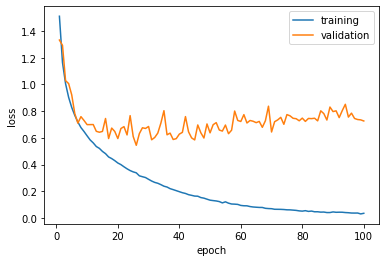

In [14]:
import matplotlib.pyplot as plt
epoch_nums = range(1, epochs+1)
training_loss = h.history["loss"]
validation_loss = h.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

In [15]:
model.save('xception_1.h5')

In [16]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 381us/sample - loss: 0.7265 - accuracy: 0.8628
Test loss: 0.7264664516210556
Test accuracy: 0.8628


In [17]:
def testImage(result):
    print(result) 
    if result[0][0]==1: 
        print("Aeroplane") 
    elif result[0][1]==1: 
        print('Automobile') 
    elif result[0][2]==1: 
        print('Bird') 
    elif result[0][3]==1: 
        print('Cat') 
    elif result[0][4]==1: 
        print('Deer') 
    elif result[0][5]==1: 
        print('Dog') 
    elif result[0][6]==1: 
        print('Frog') 
    elif result[0][7]==1: 
        print('Horse') 
    elif result[0][8]==1: 
        print('Ship') 
    elif result[0][9]==1: 
        print('Truck') 
    else:
        print('Error')

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Horse


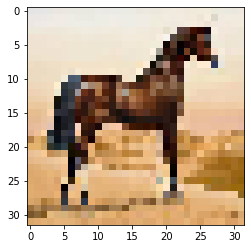

In [22]:
from keras.preprocessing import image
import numpy as np

test_image1 =image.load_img("../input/imagetest/Image/horse1.jpg",target_size =(32,32,3))
test_image =image.img_to_array(test_image1) 
test_image =np.expand_dims(test_image, axis =0) 
result = model.predict(test_image)
plt.imshow(test_image1)
testImage(result)

In [30]:
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

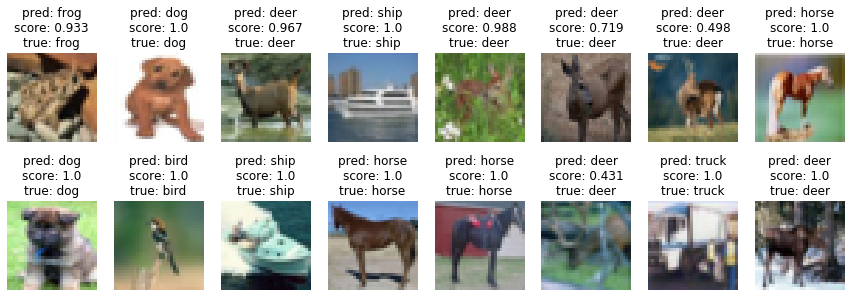

In [32]:
cols = 8
rows = 2
NUM_CLASSES = 10
# load data
(x_train2, y_train2), (x_test2, y_test2) = cifar10.load_data()
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test2))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test2[random_index, :])
        pred_label =  cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test2[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()
